## Libraries

In [1]:
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from utils import time_hour, find_first, find_non_zero_positions

## Preparing participants data

In [3]:
# List all files in the directory
files = os.listdir("PASS_BH3/")

# Load corrected markers and target data
markers_corrected = pd.read_csv("correctedMarkers.csv")
target = pd.read_csv("DATA_PASS.csv").dropna()

# Get unique participant numbers from both datasets
part_un = markers_corrected["Participant"].unique()
part = target["Participant Number"].unique()

# Find common participants
part_markcorr = np.intersect1d(part, part_un)
print("Participants present in both datasets:", part_markcorr)

Participants present in both datasets: [2104 2105 2106 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2117
 2119 2120 2121 2122 2123 2124 2125 2126 2127 2129 2130 2131 2132 2133
 2134 2136]


## Visualization of the raw ECG

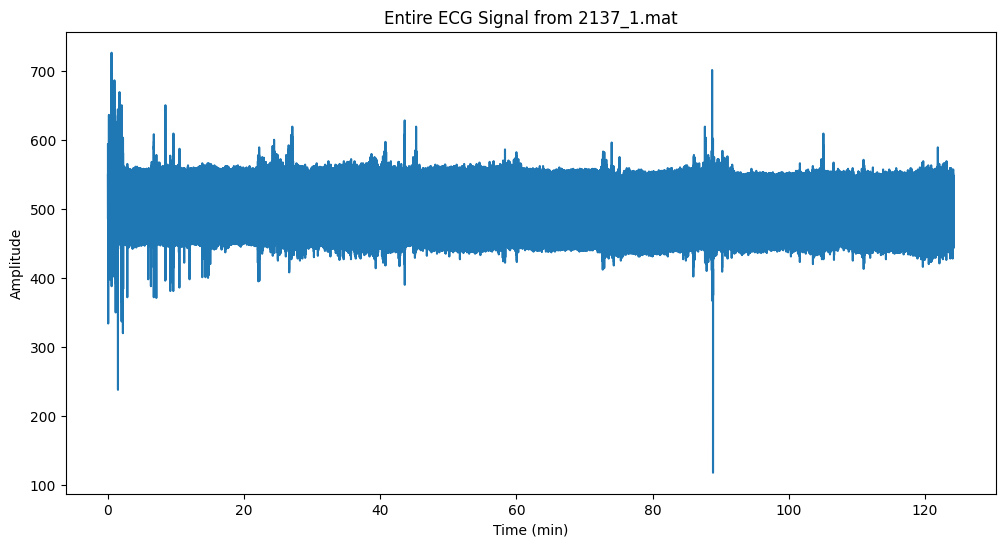

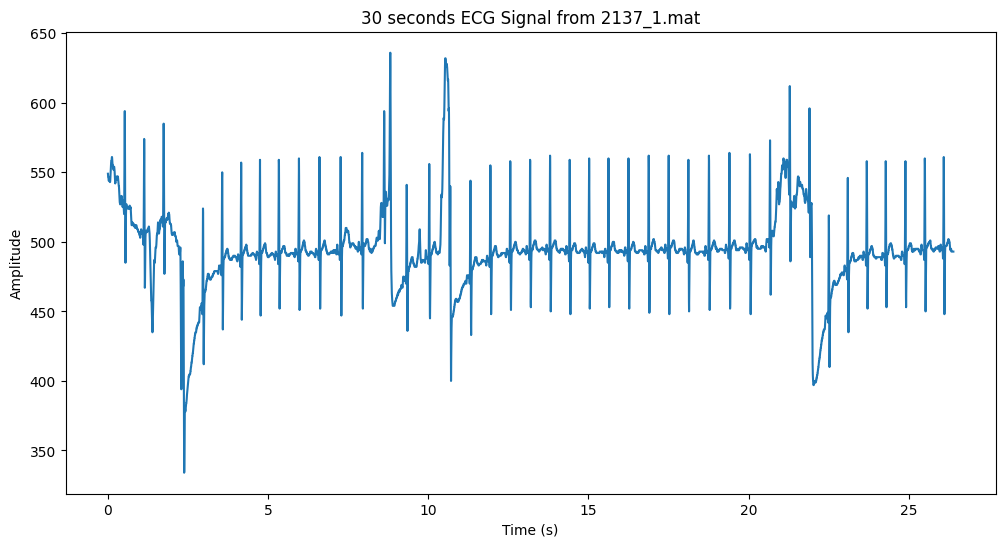

In [23]:
# Load the .mat file
mat_file = scipy.io.loadmat("PASS_BH3/2137_1.mat")

# Extract the ecg signal
ecg_signal = mat_file['data_eeg']  # the file contains a spelling error
sampling_rate = 250
time_axis = np.arange(ecg_signal.shape[0]) / sampling_rate / 60  # in minutes

plt.figure(figsize=(12, 6))
plt.plot(time_axis, ecg_signal)
plt.xlabel('Time (min)')
plt.ylabel('Amplitude')
plt.title('Entire ECG Signal from 2137_1.mat')
plt.show()

# Plot a zoomed in version of the signal
zoomed_signal = ecg_signal[:6600]  # 30 seconds of data
time_axis = np.arange(zoomed_signal.shape[0]) / sampling_rate  # in seconds
plt.figure(figsize=(12, 6))
plt.plot(time_axis, zoomed_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('30 seconds ECG Signal from 2137_1.mat')
plt.show()

## Preprocessing the signal

In [15]:
# Dictionary to store signals for each participant
participant_signals = {}

# Iterate over all files
for f in range(len(files)):
    participant_id = int(files[f][:4])
    
    # Check if the participant is in the corrected markers list
    if participant_id in part_markcorr:
        # Load the ECG signal
        signal = scipy.io.loadmat("PASS_BH3/" + files[f])['data_eeg']
        
        # Load the time markers
        time = scipy.io.loadmat("PASS_BH3_metdat/" + files[f][:4] + "_time" + files[f][4:])['data_markers']
        timestamps = list(time[:])
        time_vct = time_hour(timestamps)
        
        # Get the participant's timestamps and status from the corrected markers
        time_p = markers_corrected.loc[markers_corrected['Participant'] == participant_id, 'timestamp'].values
        status_p = markers_corrected.loc[markers_corrected['Participant'] == participant_id, 'Status'].values
        
        # Find the first occurrences of the timestamps
        first_occ = find_first(time_vct, time_p)
        
        # Dictionary to store segments for each status
        segments = {}
        counter = 0
        
        # Segment the signal based on the timestamps
        for start, end in zip(first_occ[:-1], first_occ[1:]):
            segment = signal[start:end]
            segments[status_p[counter]] = segment
            counter += 1
        
        # Store the segments for the current participant
        participant_signals[files[f][:6]] = segments


## Save the segmented signals

In [16]:
# Save the segmented signals
np.save("../Data/ecg_signals.npy", participant_signals)